# Adaptive step-size selection for ODE filters


In ProbNum the step size adaptation scheme from [Schober et al., 2019](https://arxiv.org/pdf/1610.05261.pdf) respectively [Bosch et al., 2021](https://arxiv.org/pdf/2012.08202.pdf) is implemented.


In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('../../probnum.mplstyle')

In [2]:
import numpy as np
from probnum import random_variables as rvs
from probnum.diffeq import IVP, lotkavolterra, probsolve_ivp

### IBM(1) with EK0

We start by showing how solving an IVP with adaptive steps works.

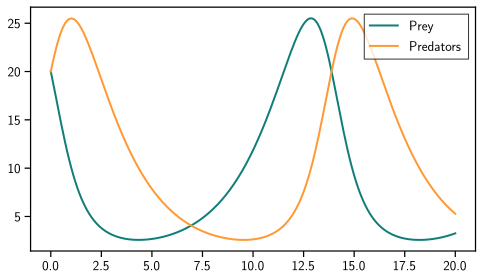

In [3]:
initrv = rvs.Constant(np.array([20, 20]))
ivp = lotkavolterra([0.0, 20.0], initrv)

f = ivp.rhs
df = ivp.jacobian
t0 = ivp.t0
tmax = ivp.tmax
y0 = ivp.initrv.mean

sol = probsolve_ivp(f, t0, tmax, y0)

evalgrid = np.linspace(t0, tmax, 200)
means = sol(evalgrid).mean

plt.plot(evalgrid, means[:, 0], label="Prey")
plt.plot(evalgrid, means[:, 1], label="Predators")
plt.legend(loc="upper right")
plt.show()

Lets visualise the individual steps.

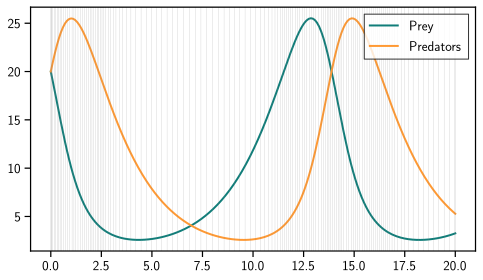

In [4]:
plt.plot(evalgrid, means[:, 0], label="Prey")
plt.plot(evalgrid, means[:, 1], label="Predators")
for t in sol.t:
    plt.axvline(t, linewidth=0.15, color="gray")
plt.legend(loc="upper right")
plt.show()

Note how more steps are taken at the inclines than at the declines. 

## The same, for a few priors

Let's consider how other priors fare in this setting.

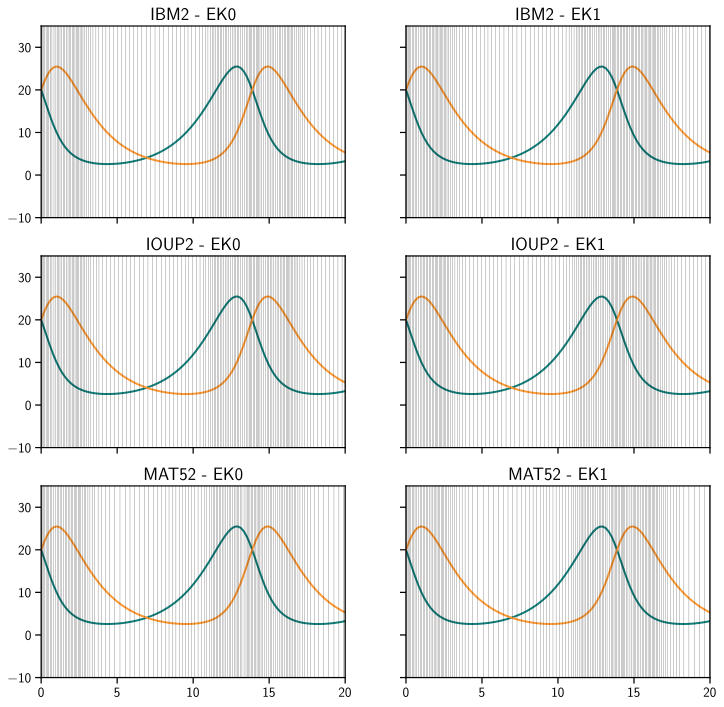

In [5]:
priors = ["IBM2", "IOUP2", "MAT52"]
filters = ["EK0", "EK1"]


fig, ax = plt.subplots(
    nrows=len(priors), ncols=len(filters), sharex=True, sharey=True, figsize=(12, 12)
)

evalgrid = np.linspace(t0, tmax, 100)

for idx in range(len(priors)):  # priors in rows
    for jdx in range(len(filters)):  # filters in cols
        sol = probsolve_ivp(f, t0, tmax, y0, df=df,
            which_prior=priors[idx],
            method=filters[jdx],
        )
        
        
        ts, means, stds = evalgrid, sol(evalgrid).mean, sol(evalgrid).std
        ax[idx][jdx].plot(ts, means)
        ax[idx][jdx].fill_between(
            ts, means[:, 0] - 3 * stds[:, 0], means[:, 0] + 3 * stds[:, 0], alpha=0.25
        )
        ax[idx][jdx].fill_between(
            ts, means[:, 1] - 3 * stds[:, 1], means[:, 1] + 3 * stds[:, 1], alpha=0.25
        )
        for t in sol.t:
            ax[idx][jdx].axvline(t, linewidth=0.2, color="black")
        ax[idx][jdx].set_title(priors[idx] + " - " + filters[jdx])
        ax[idx][jdx].set_xlim((t0, tmax))
        ax[idx][jdx].set_ylim((-10, 35))
        ax[idx][jdx].set_title(priors[idx] + " - " + filters[jdx])
plt.show()

They all seem to capture the true solution fairly well.


These experiments use default hyperparemeters for IOUP and Matern. By tuning them properly, the performance of those priors will likely be a lot better.